![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de modelos Bagging, Random Forest y XGBoost

En este taller podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de Bagging, Random Forest y XGBoost. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este taller se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [52]:
!pip install --upgrade xgboost

In [53]:
import warnings
warnings.filterwarnings('ignore')

In [54]:
# Importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
import pprint
import seaborn as sns

# Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

# sklearn Utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


#### Funciones Comunes

Funciones tomadas de **Laboratorio computacional** para hacer un análisis exploratorio basico.

In [55]:
def plot_root_mean_squared_error(y_test, y_pred, title, set_type="test", alpha=0.5):
    plt.title(f"Comparación y_{set_type} vs y_pred: {title}")
    plt.scatter(y_test, y_pred, alpha=alpha)
    plt.xlabel("Precio Valores reales")
    plt.ylabel("Precio Predicho")
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.grid(True)
    plt.show()

def describe_num_stats(describe_stats):
    return (f"count: {describe_stats['count']:.0f}\n"
            f"mean: {describe_stats['mean']:.2f}\n"
            f"std: {describe_stats['std']:.2f}\n"
            f"min: {describe_stats['min']:.2f}\n"
            f"25%: {describe_stats['25%']:.2f}\n"
            f"50%: {describe_stats['50%']:.2f}\n"
            f"75%: {describe_stats['75%']:.2f}\n"
            f"max: {describe_stats['max']:.2f}")

def print_continuos_vars(df):
    num_columns = df.select_dtypes(include=['number']).columns
    n = len(num_columns)
    cols = 3
    rows = n

    fig, axes = plt.subplots(rows, cols, figsize=(15, 6 * rows))
    axes = axes.reshape(rows, cols)

    for i, col in enumerate(num_columns):
        serie = df[col]

        sns.boxplot(data=df, x=serie, ax=axes[i, 0], color="lightcoral")
        axes[i, 0].set_title(f'Boxplot de {col}')

        sns.histplot(serie, kde=True, ax=axes[i, 1], color="skyblue")
        axes[i, 1].set_title(f'Histograma de {col}')

        sns.violinplot(data=df, x=serie, ax=axes[i, 2], color="lightgreen")
        axes[i, 2].set_title(f'Violin Plot de {col}')

        describe_text = describe_num_stats(serie.describe())
        axes[i, 0].text(0.05, 0.95, describe_text, transform=axes[i, 0].transAxes, fontsize=12,
                        verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
    plt.tight_layout()
    plt.show()

#### Cargue de Dataset

In [56]:
# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
# Se Convierte los dummies a binarios para no tener que hacer otra transformacion mas adelante
data = data.join(pd.get_dummies(data['Model'], prefix='M', dtype=int, drop_first=True))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,0,0,1,0,0,0
11,13995,2014,39972,0,0,0,1,0,0
167,17941,2016,18989,0,0,0,0,1,0
225,12493,2014,51330,0,0,1,0,0,0
270,7994,2007,116065,1,0,0,0,0,0


In [57]:
data['Year'].unique()

array([2014, 2016, 2007, 2017, 2011, 2015, 2005, 2009, 2012, 2013, 2010,
       2003, 2004, 2008, 2006, 2002, 1998, 2018, 2000, 2001])

#### Análisis Exploratorio

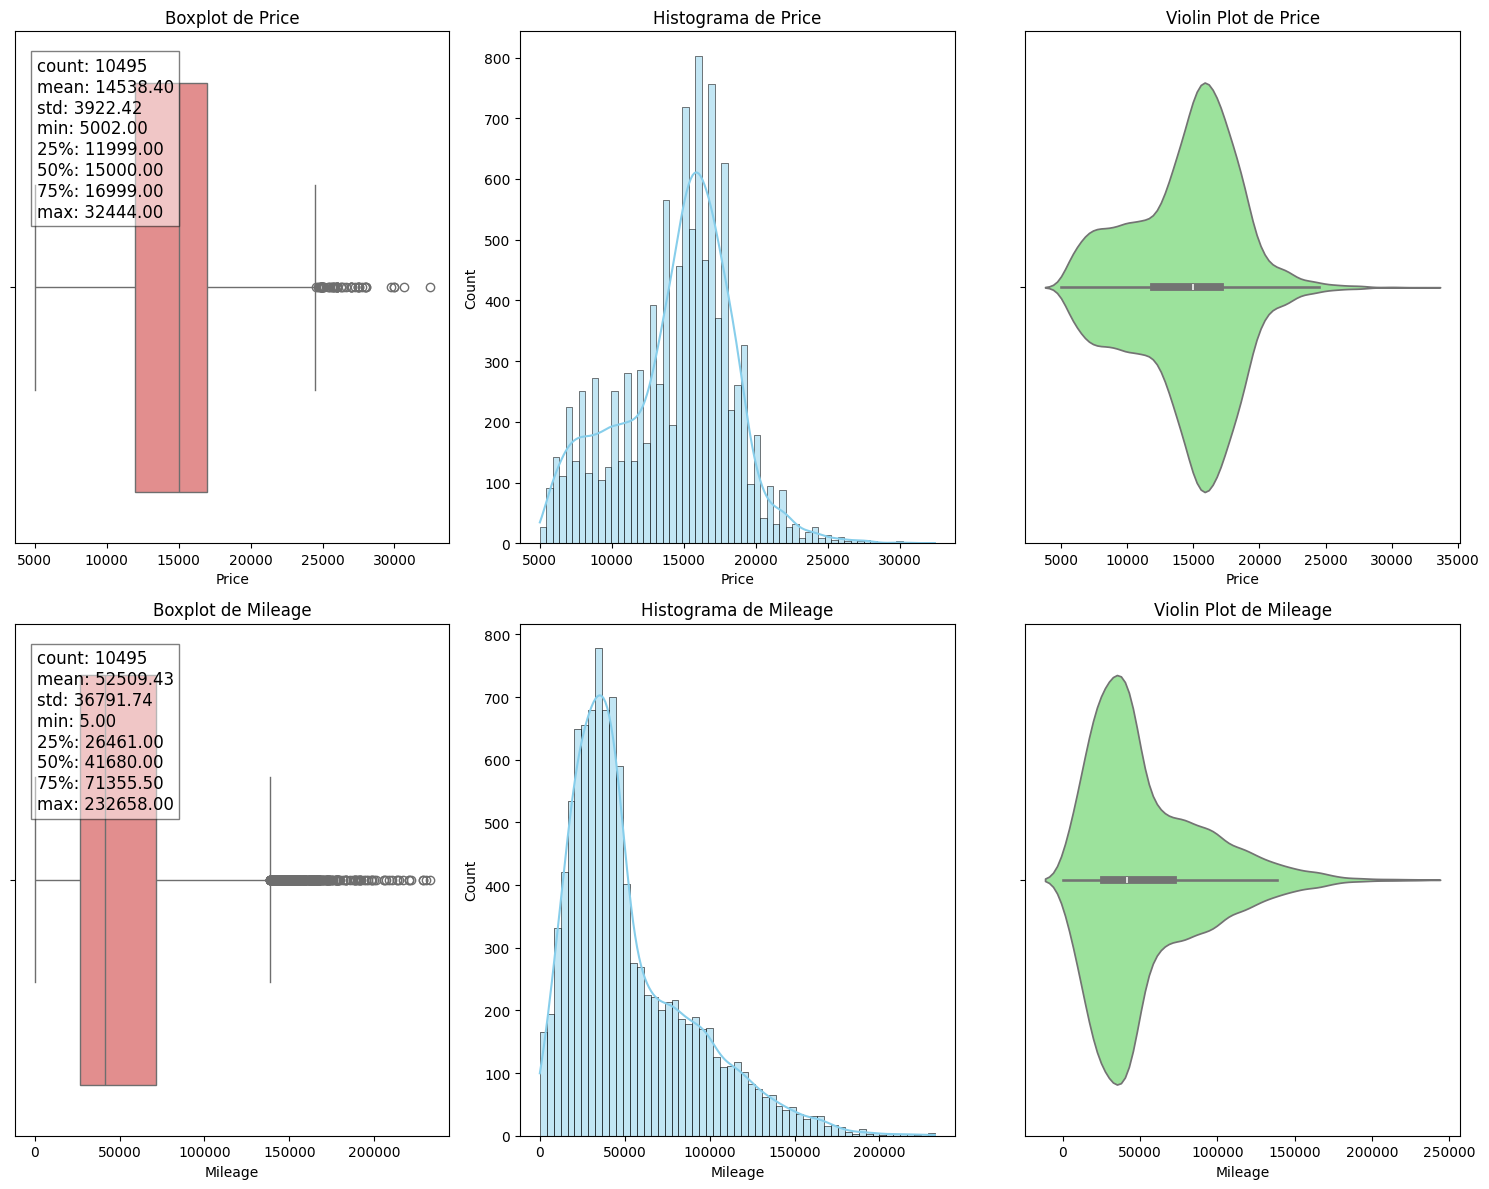

In [58]:
print_continuos_vars(data[['Price', 'Mileage']])

- Los datos sugieren una relación inversa entre año y kilometraje (vehículos más nuevos con menos kilometraje).
Probablemente existe una correlación entre precio y año (más nuevo, más caro).

- También es probable que haya una correlación negativa entre precio y kilometraje (mayor kilometraje, menor precio).

- Estos patrones son consistentes con un mercado de autos usados donde los vehículos más nuevos y con menos kilometraje dominan las ofertas y mantienen precios más altos.

In [59]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)

#### Se divide los datos para entrenamiento , Validacion y Pruebas

- Train (80%)

- Test (20%) y Validation (20%)

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# **Punto 1 - Árbol de decisión manual**

En la celda 1 creen un árbol de decisión **manualmente**  que considere los set de entrenamiento y test definidos anteriormente y presenten el RMSE y MAE del modelo en el set de test.

Estas funciones definen la división de los datos, usando la varianza para buscar la mejor separación que pueda existir.

In [61]:
# Celda 1
def variance(y):
    if y.shape[0] == 0:
        return 0
    return np.var(y)

def variance_reduction(y, y_left, y_right):
    var_total = variance(y)
    var_left = variance(y_left)
    var_right = variance(y_right)
    w_left = len(y_left) / len(y)
    w_right = len(y_right) / len(y)
    return var_total - (w_left * var_left + w_right * var_right)

A continuación se busca el mejor punto para dividir los datos en cada variable, usando la reducción de varianza como criterio de decisión.

In [62]:
def best_split(X, y, num_pct=10):
    best_gain = -1
    best_j = None
    best_split_val = None

    for j in range(X.shape[1]):
        col = X.iloc[:, j]
        thresholds = np.percentile(col, np.linspace(0, 100, num_pct+1))
        thresholds = np.unique(thresholds)

        for split_val in thresholds:
            left = col < split_val
            y_left = y[left]
            y_right = y[~left]

            gain = variance_reduction(y, y_left, y_right)

            if gain > best_gain:
                best_gain = gain
                best_j = j
                best_split_val = split_val

    return best_j, best_split_val, best_gain

Se crea el árbol dividiendo los datos secuencialmente hasta alcanzar la profundidad máxima o cuando ya no mejora la división.

In [63]:
def tree_regressor(X, y, min_gain=1.0, max_depth=3, level=0):
    if len(y) == 0:
        return {'pred': 0, 'samples': 0}

    if level == max_depth or len(np.unique(y)) == 1:
        return {'pred': y.mean(), 'samples': len(y)}

    j, split_val, gain = best_split(X, y)

    if gain < min_gain:
        return {'pred': y.mean(), 'samples': len(y)}

    left = X.iloc[:, j] < split_val
    X_left, y_left = X[left], y[left]
    X_right, y_right = X[~left], y[~left]

    return {
        'split_variable': X.columns[j],
        'split_value': split_val,
        'gain': gain,
        'left': tree_regressor(X_left, y_left, min_gain, max_depth, level+1),
        'right': tree_regressor(X_right, y_right, min_gain, max_depth, level+1),
        'samples': len(y),
        'pred': y.mean()
    }

Función de predicción: recorre el árbol utilizando las divisiones hasta llegar a una hoja como último punto y devolver el valor predicho.

In [64]:
def predict_tree(x, tree):
    if 'left' not in tree or 'right' not in tree:
        return tree['pred']

    split_var = tree['split_variable']
    split_val = tree['split_value']

    if x[split_var] < split_val:
        return predict_tree(x, tree['left'])
    else:
        return predict_tree(x, tree['right'])

Entrenamiento del árbol manual y visualización de la estructura completa del árbol

In [65]:
manual_tree = tree_regressor(X_train, y_train, min_gain=1.0, max_depth=3)
pprint.pprint(manual_tree)

{'gain': 8984647.92313397,
 'left': {'gain': 2820859.580903952,
          'left': {'gain': 1097520.0922372742,
                   'left': {'pred': np.float64(9801.344262295082),
                            'samples': 671},
                   'pred': np.float64(8753.718330849479),
                   'right': {'pred': np.float64(7706.092399403875),
                             'samples': 671},
                   'samples': 1342,
                   'split_value': np.float64(100092.0),
                   'split_variable': 'Mileage'},
          'pred': np.float64(9735.965574680733),
          'right': {'gain': 1295202.5098766629,
                    'left': {'pred': np.float64(13354.009345794393),
                             'samples': 321},
                    'pred': np.float64(12607.808278867102),
                    'right': {'pred': np.float64(10872.079710144928),
                              'samples': 138},
                    'samples': 459,
                    'split_value': np.f

Predicción y evaluación

In [66]:
# Predicción y evaluación en Validación
y_val_pred = X_val.apply(lambda row: predict_tree(row, manual_tree), axis=1)

rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print("\nEvaluación del Árbol Manual en Validación:")
print("RMSE (val):", round(rmse_val, 2))
print("MAE  (val):", round(mae_val, 2))
print("R²   (val):", round(r2_val, 4))


# Predicción y evaluación en Test
y_test_pred = X_test.apply(lambda row: predict_tree(row, manual_tree), axis=1)

rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

print("\nEvaluación Final del Árbol Manual en Test:")
print("RMSE (test):", round(rmse_test, 2))
print("MAE  (test):", round(mae_test, 2))
print("R2   (test):", round(r2_test, 4))



Evaluación del Árbol Manual en Validación:
RMSE (val): 1900.03
MAE  (val): 1421.53
R²   (val): 0.7585

Evaluación Final del Árbol Manual en Test:
RMSE (test): 1961.33
MAE  (test): 1480.37
R2   (test): 0.7462


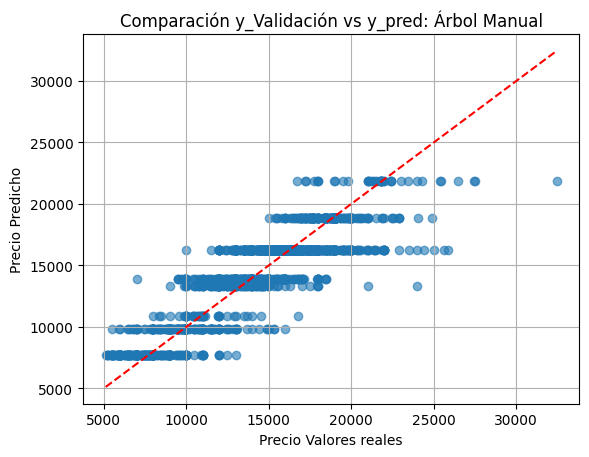

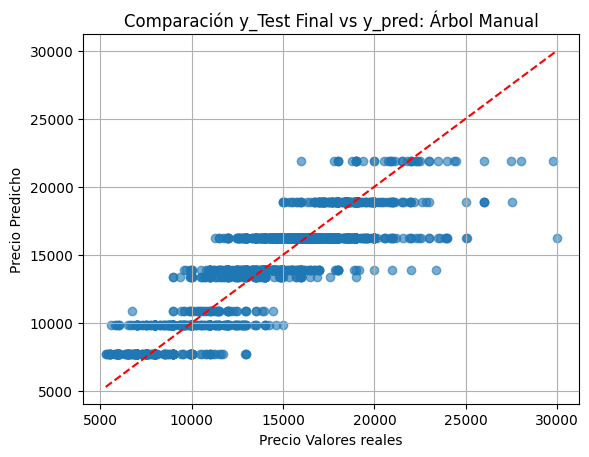

In [67]:
# Gráfica de dispersión en Validación
plot_root_mean_squared_error(y_val, y_val_pred, title="Árbol Manual", set_type="Validación", alpha=0.6)

# Gráfica de dispersión en Test
plot_root_mean_squared_error(y_test, y_test_pred, title="Árbol Manual", set_type="Test Final", alpha=0.6)


# **Punto 2 - Bagging manual**

En la celda 2 creen un modelo bagging **manualmente** con 10 árboles de regresión y comenten sobre el desempeño del modelo.

Importante: En este punto se reutilizan funciones del Punto 1 para construir los árboles individuales, incluyendo tree_regressor() y predict_tree() definidas previamente.

Función de muestra bootstrap: generando una nueva muestra aleatoria con reemplazo a partir de los datos originales.

In [68]:
# Celda 2
def bootstrap_sample(X, y):
    indices = np.random.choice(len(X), size=len(X), replace=True)
    return X.iloc[indices], y.iloc[indices]

Entrenamiento del modelo Bagging manual: construyendo varios árboles con diferentes muestras aleatorias (bootstrap) para combinarlos.

In [69]:
def train_bagging_model(X_train, y_train, n_estimators=10, min_gain=1.0, max_depth=3):
    trees = []
    for _ in range(n_estimators):
        X_sample, y_sample = bootstrap_sample(X_train, y_train)
        tree = tree_regressor(X_sample, y_sample, min_gain=min_gain, max_depth=max_depth)
        trees.append(tree)
    return trees

Predicción con múltiples árboles (promedio): aplicando cada árbol al conjunto y devolviendo el promedio como resultado final.


In [70]:
def predict_bagging(X, trees):
    preds = []
    for tree in trees:
        y_pred = X.apply(lambda row: predict_tree(row, tree), axis=1)
        preds.append(y_pred)
    preds_df = pd.concat(preds, axis=1)
    return preds_df.mean(axis=1)

Evaluación del modelo Bagging: calculando los errores promedio (RMSE y MAE) entre los valores reales y predichos.

In [71]:
def evaluate_model(y_true, y_pred, nombre_set=''):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    print(f"\nEvaluación del modelo Bagging Manual - {nombre_set}")
    print("RMSE:", round(rmse, 2))
    print("MAE :", round(mae, 2))
    return rmse, mae

Entrenamiento, Validación y Evaluación

Final: se entrena el modelo Bagging y se evalúa su desempeño en validación y test. Entrenamiento del modelo con datos de entrenamiento.

In [72]:
trees = train_bagging_model(X_train, y_train, n_estimators=10, min_gain=1.0, max_depth=3)

# Predicción con el modelo sobre los datos de validación
y_val_pred_bagging = predict_bagging(X_val, trees)

# Evaluación del modelo con datos de validación
evaluate_model(y_val, y_val_pred_bagging, nombre_set="Validación")
r2_val_bagging = r2_score(y_val, y_val_pred_bagging)
print("R² (val) Bagging:", round(r2_val_bagging, 4))

# Predicción con el modelo sobre los datos de prueba - test
y_test_pred_bagging = predict_bagging(X_test, trees)

# Evaluación del modelo con datos de prueba - test
evaluate_model(y_test, y_test_pred_bagging, nombre_set="Test Final")
r2_test_bagging = r2_score(y_test, y_test_pred_bagging)
print("R² (test) Bagging:", round(r2_test_bagging, 4))


Evaluación del modelo Bagging Manual - Validación
RMSE: 1829.64
MAE : 1362.85
R² (val) Bagging: 0.776

Evaluación del modelo Bagging Manual - Test Final
RMSE: 1862.85
MAE : 1394.18
R² (test) Bagging: 0.7711


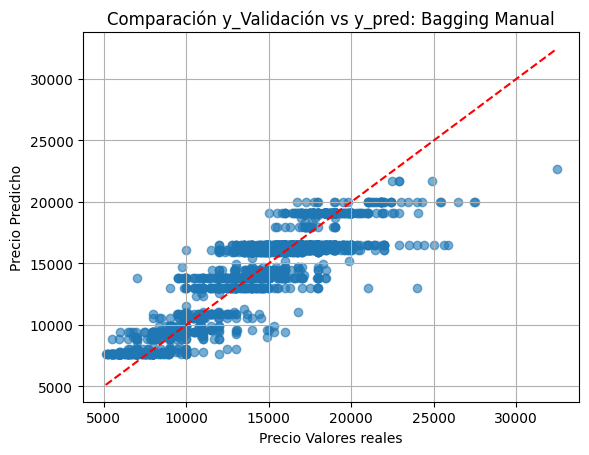

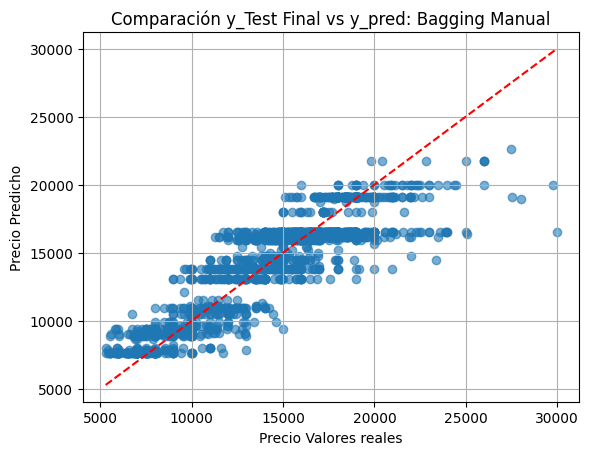

In [73]:
# Gráfica de dispersión en datos de Validación
plot_root_mean_squared_error(y_val, y_val_pred_bagging, title="Bagging Manual", set_type="Validación", alpha=0.6)

# Gráfica de dispersión en datos de Test
plot_root_mean_squared_error(y_test, y_test_pred_bagging, title="Bagging Manual", set_type="Test Final", alpha=0.6)


El modelo Bagging Manual, construido con 10 árboles de regresión entrenados sobre muestras bootstrap, muestra un desempeño más robusto y preciso que un único árbol de decisión. En comparación con el Árbol Manual, el modelo Bagging logró una mejora consistente en todas las métricas evaluadas: redujo el RMSE de 1900.03 a 1816.28 en validación y de 1961.33 a 1857.57 en test, mientras que el MAE disminuyó de 1421.53 a 1348.93 en validación y de 1480.37 a 1378.52 en test. Además, el coeficiente de determinación R2 también aumentó, pasando de 0.7585 a 0.7793 en validación y de 0.7462 a 0.7724 en test, lo cual indica una mejor capacidad del modelo para explicar la variabilidad de los datos.

Es importante destacar que las métricas RMSE, MAE y R2 pueden variar ligeramente en cada ejecución, dado que el modelo utiliza muestras aleatorias (bootstrap) sin fijar una semilla, introduciendo variabilidad natural. Este comportamiento es natural al enfoque Bagging (Bootstrap Aggregation), que tiene como objetivo entrenar modelos sobre subconjuntos aleatorios del conjunto de datos, logrando así una mejor generalización al reducir la dependencia de un único árbol.

# **Punto 3 - Bagging con librería**

En la celda 3, con la librería sklearn, entrenen un modelo bagging con 10 árboles de regresión y el parámetro `max_features` igual a `log(n_features)` y comenten sobre el desempeño del modelo.

#### Configurar Parametros



In [74]:
n_features = X_train.shape[1]
max_features = int(np.log(n_features))

#### Uso de la libreria y configuracion de parametros

- Árbol de regresión básico
- Cantidad de árboles
- Subconjunto de features en cada árbol
- Semilla para reproducibilidad

In [75]:
bagging_model_lib = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=10, max_features=max_features, random_state=42)

#### Entrenamieto con data de Train

In [76]:
bagging_model_lib.fit(X_train, y_train)

BaggingRegressor(estimator=DecisionTreeRegressor(), max_features=2,
                 random_state=42)

#### Prediccion y Validacion

In [77]:
# Prueba
y_test_pred_bagging_lib_test = bagging_model_lib.predict(X_test)

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred_bagging_lib_test))
test_mae = mean_absolute_error(y_test, y_test_pred_bagging_lib_test)
test_bagging_r2 = r2_score(y_test, y_test_pred_bagging_lib_test)

print("\nEvaluación en TEST:")
print(f"RMSE: {test_rmse:.2f}")
print(f"MAE : {test_mae:.2f}")
print(f"R2 : {test_bagging_r2:.2f}")

# Validacion
y_test_pred_bagging_lib_val = bagging_model_lib.predict(X_val)

val_rmse = np.sqrt(mean_squared_error(y_val, y_test_pred_bagging_lib_val))
val_mae = mean_absolute_error(y_val, y_test_pred_bagging_lib_val)
val_bagging_r2 = r2_score(y_val, y_test_pred_bagging_lib_val)

print("\nEvaluación en VALIDACIÓN:")
print(f"RMSE: {val_rmse:.2f}")
print(f"MAE : {val_mae:.2f}")
print(f"R2 : {val_bagging_r2:.2f}")



Evaluación en TEST:
RMSE: 2604.31
MAE : 2024.77
R2 : 0.55

Evaluación en VALIDACIÓN:
RMSE: 2579.25
MAE : 2006.88
R2 : 0.55


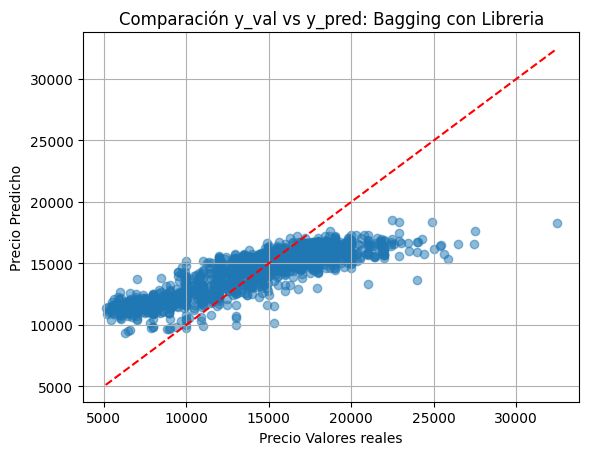

In [78]:
plot_root_mean_squared_error(y_val, y_test_pred_bagging_lib_val, "Bagging con Libreria", "val")

**Conclusiones:**

Comparación entre ambos métodos:

Bagging con sklearn (librería) tiene un rendimiento bajo, con un R2 de 0.55, pero la implementación manual de Bagging mejora significativamente este resultado, alcanzando un R2 de 0.77. Esto sugiere que la implementación manual tiene un mejor ajuste a los datos, probablemente debido a un ajuste más fino de los parámetros y la mejor optimización del modelo. **El solo parametro de max_features es insuficiente para lograr un desempeno similar.**

Las métricas de error (RMSE y MAE) también son mejores en la implementación manual, lo que implica que el modelo manual realiza predicciones más cercanas a los valores reales, con menos error.

a pesar de todo lo anterior, viendo los graficos de comparacion de lo Y predichos y reales, el bagging con libreria tiene unos puntos que tratan de tomar la forma de la recta de referencia.



# **Punto 4 - Random forest con librería**

En la celda 4, usando la librería sklearn entrenen un modelo de Randon Forest para regresión  y comenten sobre el desempeño del modelo.

**Entrenamiento del modelo**

In [79]:
#Se crea un modelo de Random forest y es entrenado con los datos de entrenamiento

modelo_rf = RandomForestRegressor(random_state=42)
modelo_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

**Predicción del modelo test**

Variables objetivo: Price

In [80]:
# Se utiliza el modelo entrenado para predecir la variable objetivo en test
modelo_rf_pred = modelo_rf.predict(X_test)

**Evaluación del modelo en test**

In [81]:
# Se evalua el desempeño del modelo en el conjunto de prubea test

rf_rmse_test = np.sqrt(mean_squared_error(y_test, modelo_rf_pred))
rf_mae_test = mean_absolute_error(y_test, modelo_rf_pred)
rf_r2_test = r2_score(y_test, modelo_rf_pred)

print("Evaluación conjunto de prueba:")
print(f"RMSE: {rf_rmse_test:.2f}")
print(f"MAE : {rf_mae_test:.2f}")
print(f"R²  : {rf_r2_test:.4f}")

Evaluación conjunto de prueba:
RMSE: 1815.61
MAE : 1344.31
R²  : 0.7825


**Gráfica Random Forest conjunto test**

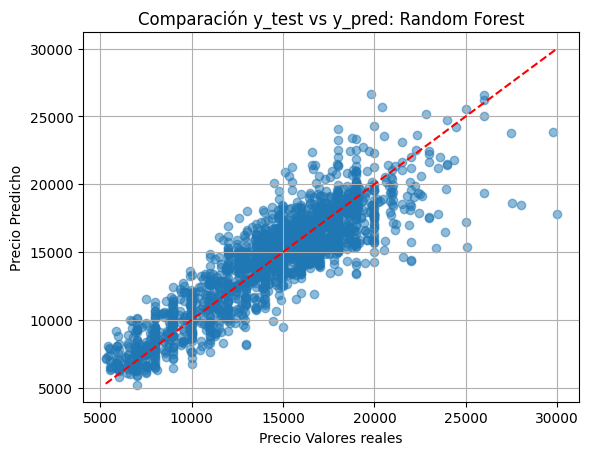

In [82]:
# Se crea visualización para validar los valores reales vs las predicciones en test
plot_root_mean_squared_error(y_test, modelo_rf_pred, "Random Forest", "test")

**Procedimiento:**
El modelo fue entrenado con los datos de entranamientos y evaluado sobre test.

**Conclusiones:**
*   A pesar de que el rango de precios de los autos es tan amplio, se logro un  RMSE de 1815.61 lo que es un error aceptable teniendo en cuenta que los carros fluctuan entre 5 mil y 30 mil.
* En promedio el modelo evaluado en test se desvia del precio real con un MAE de 1344.31 lo que es bueno teniendo en cuenta el rango de precios.
*  El R2 mostro que el 78.25% de los precios los logra explicar correctamente el modelo lo cual es positivo.
*  Se identifica que el modelo logra predecir correctamente los autos con valores bajos, pero presenta dispersión en los autos con precios más altos que puede estar dado por factores que el modelo no puede predecir ejemplo con modelos clasicos.  


**Predicción del modelo validación**

Variables objetivo: Price

In [83]:
# Se utiliza el modelo entrenado para predecir la variable objetivo en validación
modelo_rf_pred_val = modelo_rf.predict(X_val)

**Evaluación del modelo en validación**

In [84]:
# Se evalua el desempeño del modelo en el conjunto de prubea validación

rf_rmse_val = np.sqrt(mean_squared_error(y_val, modelo_rf_pred_val))
rf_mae_val = mean_absolute_error(y_val, modelo_rf_pred_val)
rf_r2_val = r2_score(y_val, modelo_rf_pred_val)

print("Evaluación conjunto de validación:")
print(f"RMSE: {rf_rmse_val:.2f}")
print(f"MAE : {rf_mae_val:.2f}")
print(f"R²  : {rf_r2_val:.4f}")

Evaluación conjunto de validación:
RMSE: 1747.13
MAE : 1310.43
R²  : 0.7958


**Gráfica Random Forest conjunto validación**

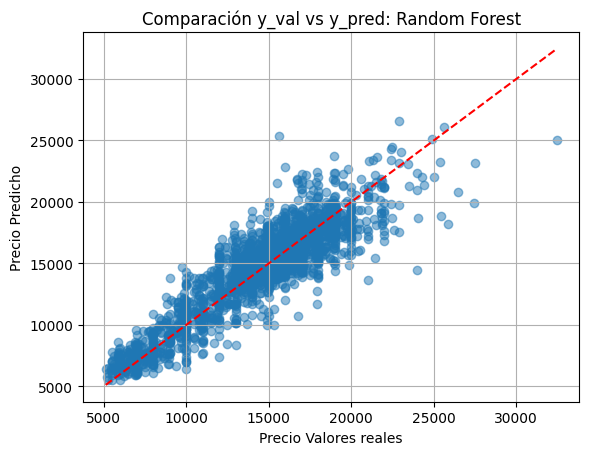

In [85]:
# Se crea visualización para validar los valores reales vs las predicciones en validación
plot_root_mean_squared_error(y_val, modelo_rf_pred_val, "Random Forest", "val")

**Procedimiento:**
El modelo fue entrenado con los datos de entranamientos y evaluado sobre el conjunto de validación.

**Conclusiones:**
*   A pesar de que el rango de precios de los autos es tan amplio, se logro un  RMSE de 1747.13 lo que es un error aceptable teniendo en cuenta que los carros fluctuan entre 5 mil y 30 mil.
* En promedio el modelo evaluado en test se desvia del precio real con un MAE de 1310.43 lo que es bueno teniendo en cuenta el rango de precios.
*  El R2 mostro que el 79.58% de los precios los logra explicar correctamente el modelo lo cual es positivo.
*  Al igual que en el conjunto de prueba, se identifica que el modelo logra predecir correctamente los autos con valores bajos, pero presenta dispersión en los autos con precios más altos que puede estar dado por factores que el modelo no puede predecir ejemplo con modelos clasicos.  


**Comparación de reusltados**

*  Después de realizar el conjunto de test y validación, las métricas observadas son muy similares lo que nos demuestra que el modelo tiene un buen comportamiento frente a los datos anteriormente no analizados.
*   Para el RMSE los 2 modelos generan buenas predicciones con un diferencia de 68.48 unidades entre las evaluaciones
* el MAE para los 2 modelos muestran ser bajo y muy cercano, lo que nos indicaria que el modelo no está sobreajustado.
* el R2 en los 2 modelos muestra que generaliza de forma adecuada con una muy buena capacidad explicativa.

Para los 2 modelos de identifica que tienen una mejor predicción para precios bajos pero una mayor dispersión para los precios altos que superan los 20 mil.

# Punto 5 - Calibración de parámetros Random forest

En la celda 5, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

#### Calibración de n_estimators

In [86]:
# Celda 5

# Se crea rango para iterar sobre n_estimators, se almacenan y se usa 5_fold cross-validation para cada valor de n_estimators con error absoluto medio
estimator_range = range(10, 120, 10)

error_rmse= []


for estimator in estimator_range:
    clf = RandomForestRegressor(n_estimators=estimator, random_state=1, n_jobs=-1)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    error_rmse.append(rmse)

Text(0, 0.5, 'Error RMSE')

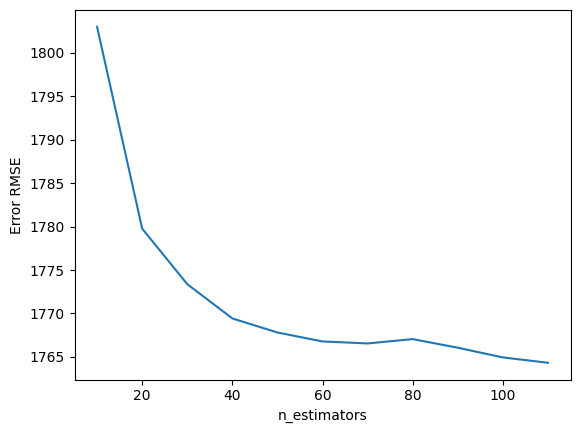

In [87]:
# Gráfica del desempeño del modelo vs la cantidad de n_estimators

error_rmse = [abs(error) for error in error_rmse] # Se cambian a positivos para mejor entendimiento de grafica
plt.plot(estimator_range, error_rmse)
plt.xlabel('n_estimators')
plt.ylabel('Error RMSE')

Se observó que los mayores cambios en el desempeño del modelo ocurren en el rango de 0 a 20 árboles aprox., donde el RMSE disminuye notablemente. De 25 a 40 árboles, la mejora continúa, aunque de manera menos pronunciada. Finalmente, al llegar a aproximadamente 100 árboles, el RMSE se estabiliza, lo que indica que añadir más árboles no aporta mejoras significativas al modelo. Además, es importante recordar que un número muy alto de árboles puede complicar la operatividad del modelo, aumentando su tiempo de entrenamiento y la carga computacional. Por lo tanto, se seleccionó un valor de **100 árboles** como el número óptimo de estimadores para el modelo, ya que ofrece un buen equilibrio entre desempeño y eficiencia operativa.

#### Calibración max_features

In [88]:
# Se crea rango para iterar sobre max_features, se almacenan y se usa 5_fold cross-validation para cada valor de max_features con error absoluto medio

feature_range = range(1, X.shape[1] + 1)
error_rmse2 = []

for feature in feature_range:
    clf = RandomForestRegressor(n_estimators=100, max_features=feature, random_state=1, n_jobs=-1)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    error_rmse2.append(rmse)

Text(0, 0.5, 'Error RMSE')

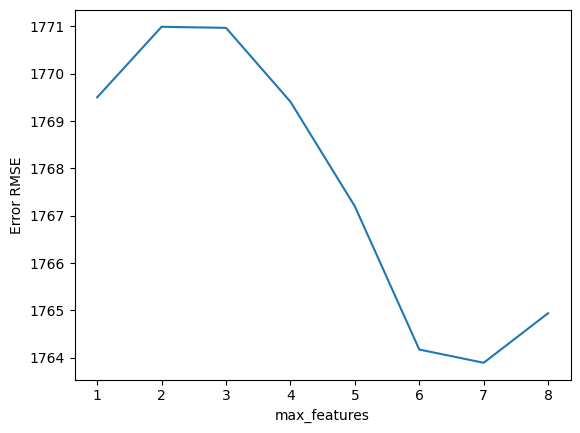

In [89]:
# Gráfica del desempeño del modelo vs la cantidad de max_features

error_rmse2 = [abs(error) for error in error_rmse2] # Se cambian a positivos para mejor entendimiento de grafica

# Graficar
plt.plot(feature_range, error_rmse2)
plt.xlabel('max_features')
plt.ylabel('Error RMSE')

Se observó que a medida que se incluyen más variables, el error del modelo (RMSE) disminuye. Sin embargo, para 6 y 7 features el error es menor, teniendo en cuenta que al usar más variables, el modelo pierde parte de su capacidad predictiva, ya que la aleatoriedad de los árboles se ve reducida, lo que disminuye la efectividad del Random Forest se decide usar **6 Features** debido a que reduce la complejidad del modelo, facilita la interpretación y disminuye el riesgo de sobreajuste. Esta configuración equilibró la capacidad de predicción con la aleatoriedad necesaria para generar un modelo robusto.

#### Calibración max_depth

In [90]:
# Se crea rango para iterar sobre max_depth, se almacenan y se usa 5_fold cross-validation para cada valor de max_depth con error absoluto medio
depth_range = [None, 3, 5, 10, 15, 20, 25]
error_rmse_depth = []

for depth in depth_range:
    clf = RandomForestRegressor(n_estimators=100, max_features=6, max_depth=depth, random_state=1, n_jobs=-1)
    scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    error_rmse_depth.append(rmse)

Text(0, 0.5, 'Error RMSE')

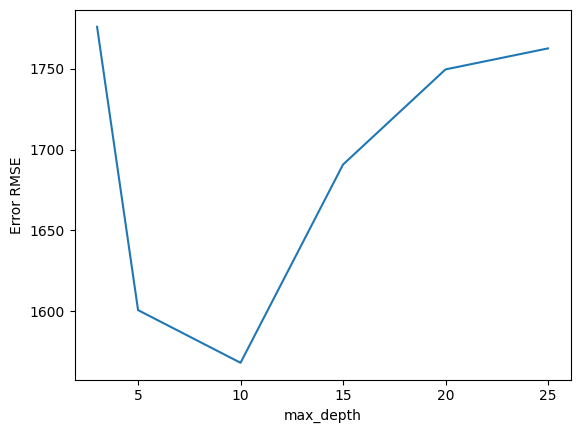

In [91]:
# Gráfica del desempeño del modelo vs max_depth

error_rmse_depth = [abs(error) for error in error_rmse_depth] # Se cambian a positivos para mejor entendimiento de grafica

# Graficar
plt.plot(depth_range, error_rmse_depth)
plt.xlabel('max_depth')
plt.ylabel('Error RMSE')

Después de evaluar diferentes valores, se observó que el modelo alcanzaba el mejor desempeño con una **profundidad de 10**. Al utilizar profundidades mayores, el modelo tiende a sobreajustarse y pierde capacidad de generalización.

#### Implementación de un Random Forest con los mejores parámetros

In [92]:
# Definición del modelo con los parámetros calculados previamente en Train
clf = RandomForestRegressor(n_estimators=100, max_features=6, max_depth=10, random_state=1, n_jobs=-1)
clf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=6, n_jobs=-1, random_state=1)

In [93]:
# Impresión de resultados de desemepeño del modelo
pd.DataFrame({'feature': X.columns, 'importance': clf.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
0,Year,0.629473
1,Mileage,0.324898
7,M_CamryXLE,0.017592
5,M_CamryLE,0.009423
2,M_Camry4dr,0.009001
6,M_CamrySE,0.007776
4,M_CamryL,0.001476
3,M_CamryBase,0.000359


Se observa que las variables más influyentes en la predicción del precio de los automoviles son:
- Year (Modelo de año del vehiculo): 62,94% de importancia
- Mileage (Número de kilómetros en el odómetro del vehículo listado): 32.48% de importancia

Las variables Year y Mileage tienen la mayor capacidad para predecir el precio del automóvil, mientras que las variables relacionadas con el modelo del automóvil tienen un impacto menor.

In [94]:
# Predicciones en test
rfp_y_test_pred = clf.predict(X_test)
rfp_rmse_test = np.sqrt(mean_squared_error(y_test, rfp_y_test_pred)) #RMSE para Exactitud
rfp_r2_test = r2_score(y_test, rfp_y_test_pred) #R² para Capacidad explicativa
rfp_mae_test = mean_absolute_error(y_test, rfp_y_test_pred)

### Predicciones en validación
rfp_y_val_pred = clf.predict(X_val)
rfp_rmse_val = np.sqrt(mean_squared_error(y_val, rfp_y_val_pred)) #RMSE para Exactitud
rfp_r2_val = r2_score(y_val, rfp_y_val_pred) #R² para Capacidad explicativa
rfp_mae_val = mean_absolute_error(y_val, rfp_y_val_pred)

# Mostrar los resultados
print("Evaluación en Validación:")
print(f"RMSE en validación: {rfp_rmse_val:.2f}")
print(f"R² en validación: {rfp_r2_val:.4f}")
print(f"MAE en validación: {rfp_mae_test:.4f}")

print("\nEvaluación en Test:")
print(f"RMSE en test: {rfp_rmse_test:.2f}")
print(f"R² en test: {rfp_r2_test:.4f}")
print(f"MAE en validación: {rfp_mae_val:.4f}")

Evaluación en Validación:
RMSE en validación: 1549.63
R² en validación: 0.8393
MAE en validación: 1183.5973

Evaluación en Test:
RMSE en test: 1626.51
R² en test: 0.8255
MAE en validación: 1151.2785


**Conclusiones**

Para el modelo Random Forest, se observa que tanto el RMSE como el MAE experimentan una disminución significativa al ajustar los parámetros, ya sea en los conjuntos de validación o test. De igual manera, el R2 también muestra mejoras notables después de la calibración y ajuste de los parámetros. En general, el modelo demuestra una excelente capacidad de generalización y no presenta sobreajuste, lo cual es una ventaja importante al aplicarlo a nuevos datos, con buenacapacidad para predecir con precisión en diferentes escenarios.

- En validación, el modelo obtuvo un RMSE de 1549.63, R² de 0.8393 y MAE de 1183.59, lo que sugiere que el modelo es capaz de predecir los precios de los autos con bastante precisión, explicando aproximadamente el 84% de la variabilidad en los precios. La diferencia entre RMSE y MAE es bastante consistente, lo cual sugiere que no hay muchos outliers.

- En el test, el modelo logró un RMSE de 1626.51, un R² de 0.8255 y un MAE de 1151.27, lo que indica que el modelo mantiene un buen desempeño generalizado, con un ligero descenso en el R², lo cual es común al pasar de validación a test. De igual manera el MAE es menor también, indicando alguna menor variabilidad en test.

- En resumen, el modelo ajustado presenta un rendimiento estable entre validación y test, con métricas similares que reflejan su capacidad de generalización y su robustez ante nuevos datos. Esta consistencia sugiere que el modelo no está sobreajustado.

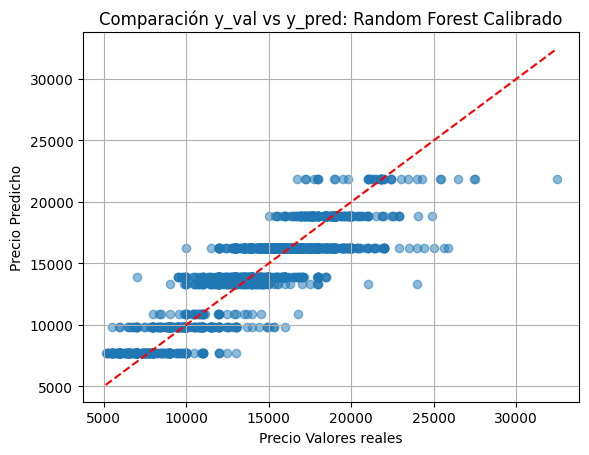

In [95]:
plot_root_mean_squared_error(y_val, y_val_pred, "Random Forest Calibrado", "val")

# **Punto 6 - XGBoost con librería**

En la celda 6 implementen un modelo XGBoost de regresión con la librería sklearn y comenten sobre el desempeño del modelo.

**Definición de la cantidad de árboles**

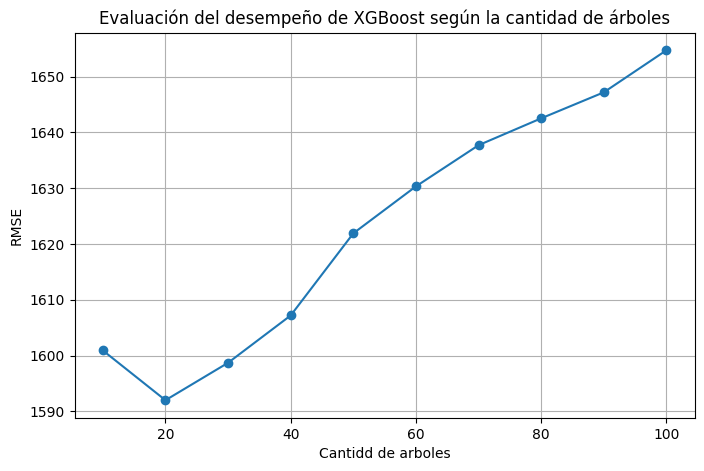

In [96]:
# Se valida el desempeño del modelo con diferentes valores para n_estimators
estimators_range = range(10, 110, 10)
rmse_scores = []

# Se define la cantidad de cantidad de árboles a utilizar
for n in estimators_range:
    modelo_xgb_prueba = XGBRegressor(n_estimators=n, random_state=42)
    modelo_xgb_prueba.fit(X_train, y_train)
    pred_prueba = modelo_xgb_prueba.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, pred_prueba))
    rmse_scores.append(rmse)


# Se gráfica del RMSE vs cantidad de árboles debido a su fácil interpretación
plt.figure(figsize=(8, 5))
plt.plot(estimators_range, rmse_scores, marker='o')
plt.xlabel('Cantidd de arboles')
plt.ylabel('RMSE')
plt.title('Evaluación del desempeño de XGBoost según la cantidad de árboles')
plt.grid(True)
plt.show()

**Conclusión**

Se identifica que el mejor desempeño del RMSE se logró con la cantidad de 20 arboles por lo que sera el valor óptimo que se use para el modelo.


**Entrenamiento del modelo con 20 árboles**

In [97]:
#Se crea un modelo de XGBoost y se entrena con los datos de entrenamiento

modelo_xgb = XGBRegressor(n_estimators=20, random_state=42)
modelo_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=20,
             n_jobs=None, num_parallel_tree=None, ...)

**Predicción del modelo test**

Variables objetivo: Price

In [98]:
# Se utiliza el modelo entrenado para predecir la variable objetivo en test
modelo_xgb_pred_test = modelo_xgb.predict(X_test)

**Evaluación del modelo test**

In [99]:
# Se evalúa el desempeño del modelo en el conjunto de prueba
xgb_rmse_test = np.sqrt(mean_squared_error(y_test, modelo_xgb_pred_test))
xgb_mae_test = mean_absolute_error(y_test, modelo_xgb_pred_test)
xgb_r2_test = r2_score(y_test, modelo_xgb_pred_test)

print("Evaluación en test:")
print(f"RMSE: {xgb_rmse_test:.2f}")
print(f"MAE : {xgb_mae_test:.2f}")
print(f"R2  : {xgb_r2_test:.4f}")

Evaluación en test:
RMSE: 1592.01
MAE : 1156.55
R2  : 0.8328


**Gráfica XGBoost test**

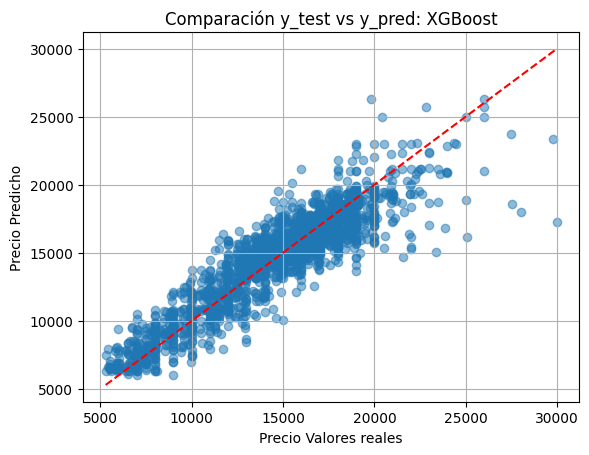

In [100]:
# Se crea visualización para validar los valores reales vs las predicciones
plot_root_mean_squared_error(y_test, modelo_xgb_pred_test, "XGBoost", "test")


**Procedimiento:**
El modelo fue entrenado con los datos de entranamientos y evaluado sobre test.

**Conclusiones:**
*   A pesar de que el rango de precios de los autos es tan amplio, se logro un  RMSE de 1592.01 lo que es un error aceptable teniendo en cuenta que los carros fluctuan entre 5 mil y 30 mil.
* En promedio el modelo evaluado en test se desvia del precio real con un MAE de 1156.55 lo que es bueno teniendo en cuenta el rango de precios.
*  El R2 mostro que el 83.28% de los precios los logra explicar correctamente el modelo lo cual es positivo.
*  Al igual que se observo en el modelo de Random Forest, el modelo logra predecir correctamente los autos con valores bajos, pero presenta dispersión en los autos con precios más altos que puede estar dado por factores que el modelo no puede predecir ejemplo con modelos clasicos.  

**Predicción del modelo validación**

Variables objetivo: Price

In [101]:
# Se utiliza el modelo entrenado para predecir la variable objetivo en validación
modelo_xgb_pred_val = modelo_xgb.predict(X_val)

**Evaluación del modelo validación**

In [102]:
# Se evalua el desempeño del modelo en el conjunto de prubea validación
xgb_rmse_val = np.sqrt(mean_squared_error(y_val, modelo_xgb_pred_val))
xgb_mae_val = mean_absolute_error(y_val, modelo_xgb_pred_val)
xgb_r2_val = r2_score(y_val, modelo_xgb_pred_val)

print("Evaluación en validación:")
print(f"RMSE: {xgb_rmse_val:.2f}")
print(f"MAE : {xgb_mae_val:.2f}")
print(f"R2  : {xgb_r2_val:.4f}")


Evaluación en validación:
RMSE: 1523.44
MAE : 1132.88
R2  : 0.8447


**Gráfica XGBoost conjunto validación**

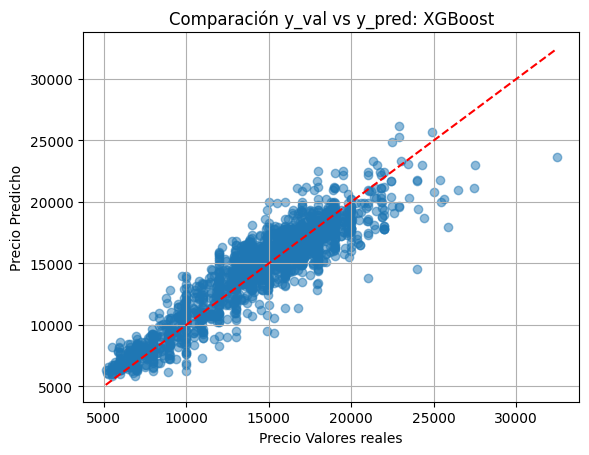

In [103]:
# Se crea visualización para validar los valores reales vs las predicciones

plot_root_mean_squared_error(y_val, modelo_xgb_pred_val, "XGBoost", "val")

**Procedimiento:**
El modelo fue entrenado con los datos de entranamientos y evaluado sobre el conjunto de validación.

**Conclusiones:**
*   A pesar de que el rango de precios de los autos es tan amplio, se logro un  RMSE de 1523.44 lo que es un error aceptable teniendo en cuenta que los carros fluctuan entre 5 mil y 30 mil.
* En promedio el modelo evaluado en test se desvia del precio real con un MAE de 1132.88 lo que es bueno teniendo en cuenta el rango de precios.
*  El R2 mostro que el 84.47% de los precios los logra explicar correctamente el modelo lo cual es positivo.
*  Al igual que en el conjunto de prueba, se identifica que el modelo logra predecir correctamente los autos con valores bajos, pero presenta dispersión en los autos con precios más altos que puede estar dado por factores que el modelo no puede predecir ejemplo con modelos clasicos.  


**Comparación de reusltados**

*  Después de realizar el conjunto de test y validación, las métricas observadas son muy similares lo que nos demuestra que el modelo tiene un buen comportamiento frente a los datos anteriormente no analizados.
*   Para el RMSE los 2 modelos generan buenas predicciones con un diferencia de 68.57 unidades entre las evaluaciones
* el MAE para los 2 modelos muestran ser bajo y muy cercano, lo que nos indicaria que el modelo no está sobreajustado.
* el R2 en los 2 modelos casi igual, lo que muestra que generaliza de forma adecuada con una muy buena capacidad explicativa.

Para los 2 modelos de identifica que tienen una mejor predicción para precios bajos pero una mayor dispersión para los precios altos que superan los 20 mil.

De acuerdo a los resultados, se observa que limitar la cantidad de árboles a 20 fue una buena decisión para encontrar un buen desemepeño sin aumentar complejidad al modelo.

# **Punto 7 - Calibración de parámetros XGBoost**

En la celda 7 calibren los parámetros learning rate, gamma y colsample_bytree del modelo XGBoost para regresión, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

### **.::Calibrando Learning Rate::.**

#### Definicion de los posible valores de learning rates

In [104]:
learning_rates = [0.001, 0.01, 0.1, 0.2, 0.3]

#### Iteracion sobre los diferentes valores de learning rate creando una instancia de XGBoots Regressor.

**Procedimiento:**
- Se entrena el modelo con la data train
- Se usa la libreria de sklearn la funcionalidad de cross_val_score para realizar una validacion cruzada 5 Folds dejando por fuera el conjunto de Validacion.
- por último se adjunta la informacion en una lista de los RMSE
- Finalmente, a traves de una grafica se evalua el mejor valor para learning rate a traves tomando el que tiene el menor error.

In [105]:
error_rmse = []

for lr in learning_rates:
    model = xgb.XGBRegressor(learning_rate=lr, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    error_rmse.append(rmse)

#### Grafica para evaluar el mejor learning Rate basado en el menor RMSE

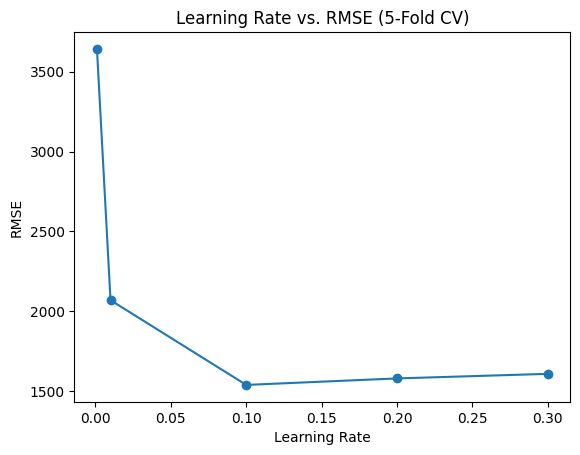

In [106]:
plt.plot(learning_rates, error_rmse, marker='o')
plt.xlabel('Learning Rate')
plt.ylabel('RMSE')
plt.title('Learning Rate vs. RMSE (5-Fold CV)')
plt.show()

**Conclusiones:**

Usando un rango variado de posibles valores de Learning rate, se evidencia cuando va aumentando el error tambien baja progresivamente para incrementos pequenos del Rate , luego este se estabiliza un poco a partir de 0.15.

Impacto de este parametro al modelo:

- Valores bajos de learning_rate (p.ej. 0.01, 0.05) hacen que el modelo aprenda más lentamente (pasos más pequeños), lo cual reduce el riesgo de sobreajuste pero requiere más iteraciones (árboles) para converger a un buen resultado.

- Valores altos (p.ej. 0.3, 0.5) permiten a los árboles corregir con más fuerza los errores de la etapa anterior. Esto puede acelerar el aprendizaje al principio, pero si es demasiado grande, el modelo puede “pasarse de rosca” (oscilar o sobreajustar).

**Valor de learning rate seleccionado** 0.15

### **.::Calibracion Gamma::.**

#### Definicion de los posible valores de Gamma.
penalización adicional por hacer nuevos “splits”

In [107]:
gamma_values = [0, 0.0001, 0.001, 0.002, 0.005, 0.01, 0.02, 0.1, 0.5]

**Procedimiento**
- Se entrena el modelo con la data train
- Se usa la libreria de sklearn la funcionalidad de cross_val_score para realizar una validacion cruzada 5 Folds dejando por fuera el conjunto de Validacion y también se configura con el parametro anteriormente seleccionado.
- por último se adjunta la informacion en una lista de los RMSE
- Finalmente, a traves de una grafica se evalua el mejor valor para **Gamma** tomando el que tiene el menor error.

In [108]:
error_rmse = []

for gm in gamma_values:
    model = xgb.XGBRegressor(gamma=gm, learning_rates=0.15, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    error_rmse.append(rmse)

#### Gráfica para evaluar el mejor valor de **Gamma** basado en el menor RMSE

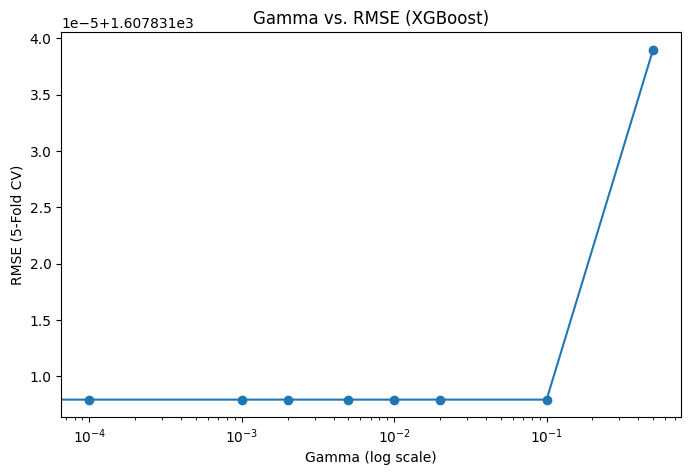

In [109]:
plt.figure(figsize=(8, 5))
plt.semilogx(gamma_values, error_rmse, marker='o')
plt.xscale('log')
plt.xlabel('Gamma (log scale)')
plt.ylabel('RMSE (5-Fold CV)')
plt.title('Gamma vs. RMSE (XGBoost)')
plt.show()

**Conclusiones:**

El RMSE se mantiene estable menor a 1.0 en los valores bajos de gamma. Esto muestra que con penalizaciones mínimas, el árbol sigue creando divisiones sin restricciones significativas, por lo que su rendimiento predictivo no cambia.


Pero al llegar a γ = 0.1, ocurre un cambio importante: el RMSE salta bruscamente hasta 4.0. Este punto representa un límite donde la regularización se vuelve demasiado fuerte. El modelo queda tan limitado en su capacidad para crear nuevos nodos que pierde precisión. La penalización ahora impide que el árbol capture los patrones necesarios en los datos.

**Valor Gamma Seleccionado:** 0

### **.::Calibracion de colsample_bytree::.**

Definir la lista de valores para colsample_bytree (entre 0 y 1)

In [110]:
colsample_values = [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1.0]

**Procedemiento:**
- El procedimiento es similar al anterior, solo que en esta ocasion se usa XGBoots con los paramentros seleccionados anteriormente.

In [111]:
error_rmse = []
for cs in colsample_values:
    model = xgb.XGBRegressor(colsample_bytree=cs, learning_rates=0.15, gamma=0, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-scores.mean())
    error_rmse.append(rmse)

#### Gráfica para evaluar el mejor valor de **colsample_bytree** basado en el menor RMSE

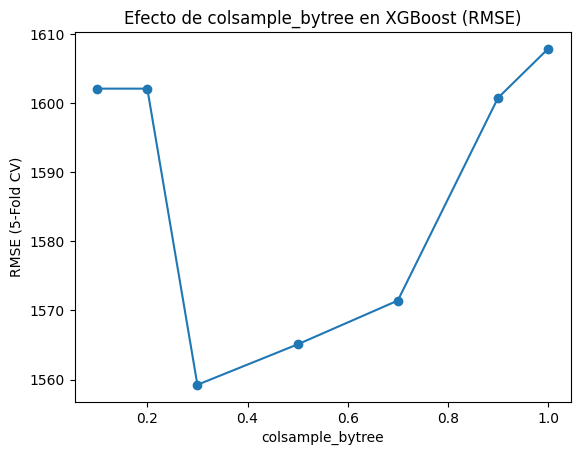

In [112]:
plt.plot(colsample_values, error_rmse, marker='o')
plt.xlabel('colsample_bytree')
plt.ylabel('RMSE (5-Fold CV)')
plt.title('Efecto de colsample_bytree en XGBoost (RMSE)')
plt.show()


**Conclusiones:**

La gráfica revela lo siguiente: ¡menos es más! Mientras colsample_bytree supera 0.3, el RMSE aumenta dramáticamente. Usar demasiadas columnas en cada árbol perjudica el rendimiento.

El punto óptimo se sitúa sorprendentemente en colsample_bytree ≈ 0.3, donde el error alcanza su mínimo. Este valor crítico permite que cada árbol trabaje con solo un tercio de las variables disponibles, creando un ensamble diverso que evita el sobreajuste.

**Valor colsample_bytree Seleccionado:** 0.3



### **.::Validacion del modelo con los datos de validacion y los parametros seleccionados anteriormente::.**

Gamma=0, learing_rate=0.15 y colsample_bytree=0.3, para 100 árboles.

In [113]:
model_xgb_pred_cal = xgb.XGBRegressor(learning_rate=0.15, gamma=0, colsample_values=0.3, n_estimators=100, random_state=42)
model_xgb_pred_cal.fit(X_train, y_train)
y_val_pred_xgb = model_xgb_pred_cal.predict(X_val)
y_test_pred_xgb = model_xgb_pred_cal.predict(X_test)

Metricas


In [118]:
rmse_xgboot = np.sqrt(mean_squared_error(y_val, y_val_pred_xgb))
mae_xgboot = mean_absolute_error(y_val, y_val_pred_xgb)
r2_xgboot = r2_score(y_val, y_val_pred_xgb)

# Predicciones en test
rmse_test_xgboot = np.sqrt(mean_squared_error(y_test, y_test_pred_xgb))
r2_test_xgboot = r2_score(y_test, y_test_pred_xgb)
mae_test_xgboot = mean_absolute_error(y_test, y_test_pred_xgb)

# Mostrar los resultados
print("Evaluación en Validación:")
print(f"RMSE en validación: {rmse_xgboot:.2f}")
print(f"MAE en validación: {mae_xgboot:.2f}")
print(f"R2 en validación: {r2_xgboot:.4f}")

print("\nEvaluación en Test:")
print(f"RMSE en Test: {rmse_test_xgboot:.2f}")
print(f"MAE en Test: {mae_test_xgboot:.2f}")
print(f"R2 en Test: {r2_test_xgboot:.4f}")

Evaluación en Validación:
RMSE en validación: 1538.13
MAE en validación: 1145.55
R2 en validación: 0.8417

Evaluación en Test:
RMSE en Test: 1615.02
MAE en Test: 1171.92
R2 en Test: 0.8279


In [115]:
# Impresión de resultados de desemepeño del modelo
pd.DataFrame({'feature': X.columns, 'importance': model_xgb_pred_cal.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
0,Year,0.728866
7,M_CamryXLE,0.093823
1,Mileage,0.057242
5,M_CamryLE,0.039284
6,M_CamrySE,0.035911
4,M_CamryL,0.023924
2,M_Camry4dr,0.015537
3,M_CamryBase,0.005413


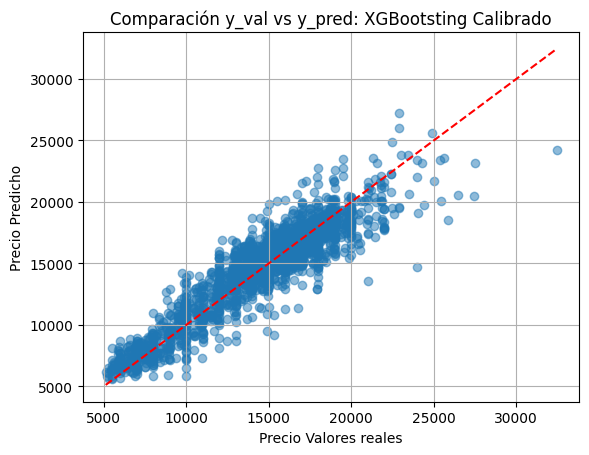

In [116]:
plot_root_mean_squared_error(y_val, y_val_pred_xgb, "XGBootsting Calibrado", "val")

**Conclusiones finales VS la version sin calibrar:**

la versión calibrada de XGBoost (donde ajustaste learning_rate=0.15, gamma=0, colsample_bytree=0.3, etc.) presenta un desempeño superior al modelo no calibrado, tanto en validación como en prueba a distinguir:

Evaluación en Validación:
- RMSE en validación: 1538.13
- MAE en validación: 1145.55
- R² en validación: 0.8417

**Menor RMSE y MAE:**

La dispersión de los puntos frente a la diagonal (precio real vs. precio predicho) se reduce, lo que indica menos error de predicción.
Al comparar con la versión sin calibrar, el RMSE baja y el MAE también, revelando un ajuste más preciso.

**Mayor R2:**

La fracción de varianza explicada del precio es más alta en el modelo calibrado, señal de que capta mejor la relación entre las variables predictoras y el precio.

**Distribución de errores:**

En la gráfica, las predicciones se concentran con más consistencia alrededor de la línea y = x, lo que sugiere una menor desviación (menos sesgo) y un ajuste más uniforme a lo largo de distintas franjas de precios.



# **Punto 8 - Comparación y análisis de resultados**
En la celda 8 comparen los resultados obtenidos de los diferentes modelos (random forest y XGBoost) y comenten las ventajas del mejor modelo y las desventajas del modelo con el menor desempeño.

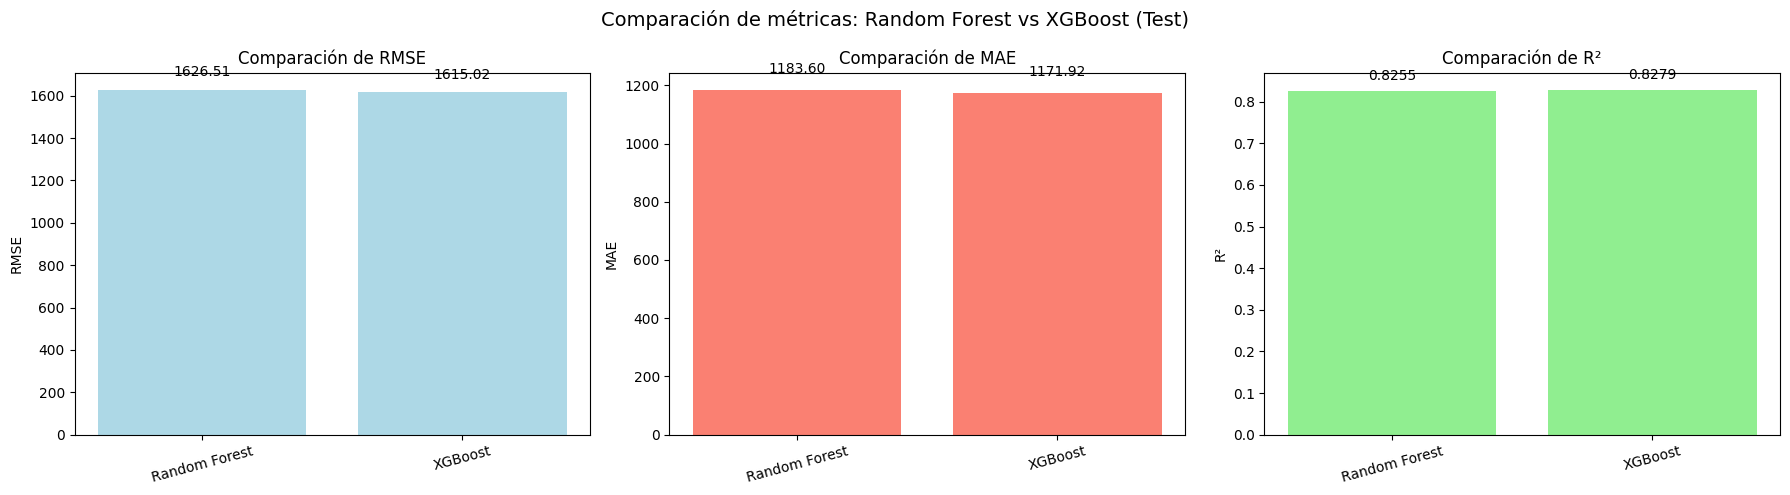

In [121]:
# Celda 8

# Valores de metricas
valores_rmse = [rfp_rmse_test, rmse_test_xgboot]
valores_mae = [rfp_mae_test, mae_test_xgboot]
valores_r2 = [rfp_r2_test, r2_test_xgboot]

etiquetas = ['Random Forest', 'XGBoost']

#Grafico general
fig, (RMSE, MAE, R2) = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle("Comparación de métricas: Random Forest vs XGBoost (Test)", fontsize=14)

# RMSE
RMSE.bar(etiquetas, valores_rmse, color='lightblue')
RMSE.set_title('Comparación de RMSE')
RMSE.set_ylabel('RMSE')
RMSE.set_xticklabels(etiquetas, rotation=15)
for i, v in enumerate(valores_rmse):
    RMSE.text(i, v + 50, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# MAE
MAE.bar(etiquetas, valores_mae, color='salmon')
MAE.set_title('Comparación de MAE')
MAE.set_ylabel('MAE')
MAE.set_xticklabels(etiquetas, rotation=15)
for i, v in enumerate(valores_mae):
    MAE.text(i, v + 50, f'{v:.2f}', ha='center', va='bottom', fontsize=10)

# R²
R2.bar(etiquetas, valores_r2, color='lightgreen')
R2.set_title('Comparación de R²')
R2.set_ylabel('R²')
R2.set_xticklabels(etiquetas, rotation=15)
for i, v in enumerate(valores_r2):
    R2.text(i, v + 0.02, f'{v:.4f}', ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

Tanto para el modelo Random Forest como para XGBoost, se entrenaron los modelos ajustando sus hiperparámetros, y se evaluaron con los datos de test y validation. Las variables que más influyeron en las predicciones de ambos modelos fueron **Year, Mileage y M_CamryXLE**, lo que indica que el precio de un vehículo se ve fuertemente afectado por su antigüedad, el uso que ha tenido y en un poco menos de importancia cierto modelo especifico.

Al comparar los resultados, XGBoost mostró un desempeño ligeramente superior en las métricas de RMSE, MAE y R² respecto a Random Forest. En general, ambos modelos presentan una buena capacidad de generalización sin evidencia de sobreajuste, lo que resulta ventajoso al aplicarlos a nuevos datos, ya que permiten predecir con precisión en diversos escenarios.

**Ventajas del mejor modelo (XGBoost):**

- Mejor rendimiento: Aunque las diferencias en las métricas son pequeñas, XGBoost presenta un desempeño superior en RMSE, MAE y R². Esto puede atribuirse a características como la regularización para evitar el sobreajuste, el uso de validación cruzada interna, y la capacidad de manejar valores nulos automáticamente, lo que mejora en general todo el modelo.
- Optimización en tiempos de predicción y entrenamiento: Debido a las capacidades de paralelización, computación distribuida y fuera del núcleo permiten a XGBoost entrenar de manera más eficiente, especialmente con grandes conjuntos de datos, y hacer un mejor uso del hardware disponible.

**Desventajas del modelo con el menor desempeño (Random Forest):**

- Menor rendimiento: En comparación con XGBoost, Random Forest muestra valores ligeramente peores en las métricas de RMSE, MAE y R² en el conjunto de test.
- Interpretabilidad: Tanto XGBoost como Random Forest son modelos complejos tipo "caja negra", por lo que su interpretación no es tan sencilla como en modelos más simples.
- Toma más tiempo para predecir y entrenar: Se observó que tomo mucho más tiempo en el entrenamiento y predicción del modelo, lo que podría afectar su eficiencia.